The notebook covers the following key steps:

- Data Loading and Exploration: Load the dataset and perform initial exploration to understand its structure, feature types, and any missing values.

- Exploratory Data Analysis (EDA): Conduct an in-depth analysis of the dataset, including visualizations and statistical summaries, to gain insights into the distribution and relationships between variables.

- Feature Engineering: Transform and engineer new features based on the existing variables to capture additional information and improve the predictive power of the model.

- Feature Selection: Select the most relevant features that have a significant impact on customer churn prediction.

- Predictive Modeling: Build and evaluate predictive models using machine learning algorithms to predict customer churn and measure their performance.

- Model Interpretation and Insights: Analyze the model results, feature importances, and coefficients to extract meaningful insights and actionable recommendations to reduce churn and improve customer retention.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap
from operator import attrgetter

# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pycaret.classification import ClassificationExperiment

import pycaret as py
import scipy as sc

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

seed = 0

In [2]:
print("Pycaret Version:", py.__version__)
print("Scipy Version:", sc.__version__)


Pycaret Version: 3.0.4
Scipy Version: 1.11.1


# Data Loading and Exploration

In [3]:
df_y = pd.read_csv('y_train.csv')
df_demo = pd.read_csv('demo.csv')
df_cardinfo = pd.read_csv('card_info.csv')
df_cctxn = pd.read_csv('cc_txn.csv')
df_sabal = pd.read_csv('sa_bal.csv')
df_dtxn = pd.read_csv('dtxn.csv')

all_df = {'df_y - Output for selected user ids':df_y,
        'df_demo - Personal information of customers':df_demo,
        'df_cardinfo - Credit card information':df_cardinfo,
        'df_cctxn - Credit card transaction log':df_cctxn,
        'df_sabal - Saving account balance aggregated by months':df_sabal,
        'df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions)':df_dtxn}

# all_df = [df_y, df_demo, df_cardinfo, df_cctxn, df_sabal, df_dtxn]

In [4]:
# head
for df in all_df:
    print(f"Head of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df].head(3))
    print('\n' + '='*50 + '\n')

Head of DataFrame: df_y - Output for selected user ids - (494, 2):


,user_id,label
0,2723,1.0
1,44088,1.0
2,3139,0.0




Head of DataFrame: df_demo - Personal information of customers - (52762, 7):


,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code
0,27616,1975-04-15,1961.0,F,,06,04
1,14619,1971-01-31,1943.0,F,1,04,09
2,13595,1960-11-24,1952.0,F,1,07,07




Head of DataFrame: df_cardinfo - Credit card information - (60296, 4):


,user_id,bill_cyc,cr_lmt_amt,card_no
0,0,17.0,244000,0
1,1,12.0,361000,1
2,2,12.0,385000,2




Head of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):


,mcc,txn_dt,user_id,txn_amt,card_no
0,mcc_cat10,2017-04-12,17863,16391.0,21616.0
1,mcc_cat11,2017-07-12,7682,117200.0,9438.0
2,mcc_cat12,2017-05-23,33603,55602.0,39476.0




Head of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):


,user_id,mm,max_sa_bal
0,0,1,535052.0
1,0,10,0.0
2,0,11,161530.0




Head of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):


,user_id,mm,amt_in,amt_out
0,0,1,17725.0,4490.0
1,0,2,12431.0,29286.0
2,0,3,86274.0,0.0


In [5]:
# null checking
for df in all_df:
    print(f"Null check of DataFrame: {df} - {all_df[df].shape}:")

    # Clean undetectable null values
    for col in all_df[df].columns:
        if all_df[df][col].dtype == 'O':  # 'O' represents object (string) type
            all_df[df][col] = all_df[df][col].str.strip()

    all_df[df].replace('', np.nan, inplace=True)

    print(round(all_df[df].isnull().sum()/len(all_df[df]),4))

    print('\n' + '='*50 + '\n')

Null check of DataFrame: df_y - Output for selected user ids - (494, 2):
user_id    0.0
label      0.0
dtype: float64


Null check of DataFrame: df_demo - Personal information of customers - (52762, 7):
user_id                           0.0000
account_start_date                0.0000
birth_year                        0.0000
gender                            0.0000
marital_status                    0.2330
family_income_segment_code        0.1293
individual_income_segment_code    0.0606
dtype: float64


Null check of DataFrame: df_cardinfo - Credit card information - (60296, 4):
user_id       0.0
bill_cyc      0.0
cr_lmt_amt    0.0
card_no       0.0
dtype: float64


Null check of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):
mcc        0.0
txn_dt     0.0
user_id    0.0
txn_amt    0.0
card_no    0.0
dtype: float64


Null check of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):
user_id       0.0
mm            0.0
max_sa_bal    0.0
dtype:

In [6]:
# info
for df in all_df:
    print(f"Info of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df].info())
    print('\n' + '='*50 + '\n')

Info of DataFrame: df_y - Output for selected user ids - (494, 2):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  494 non-null    int64  
 1   label    494 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.8 KB


None



Info of DataFrame: df_demo - Personal information of customers - (52762, 7):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52762 entries, 0 to 52761
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         52762 non-null  int64  
 1   account_start_date              52762 non-null  object 
 2   birth_year                      52762 non-null  float64
 3   gender                          52762 non-null  object 
 4   marital_status                  40467 non-null  object 
 5   family_income_segment_code      45940 non-null  object 
 6   individual_income_segment_code  49563 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.8+ MB


None



Info of DataFrame: df_cardinfo - Credit card information - (60296, 4):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60296 entries, 0 to 60295
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     60296 non-null  int64  
 1   bill_cyc    60296 non-null  float64
 2   cr_lmt_amt  60296 non-null  int64  
 3   card_no     60296 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.8 MB


None



Info of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223075 entries, 0 to 3223074
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   mcc      object 
 1   txn_dt   object 
 2   user_id  int64  
 3   txn_amt  float64
 4   card_no  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 123.0+ MB


None



Info of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633144 entries, 0 to 633143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     633144 non-null  int64  
 1   mm          633144 non-null  int64  
 2   max_sa_bal  633144 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 14.5 MB


None



Info of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490599 entries, 0 to 490598
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  490599 non-null  int64  
 1   mm       490599 non-null  int64  
 2   amt_in   490599 non-null  float64
 3   amt_out  490599 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 15.0 MB


None

In [7]:
# duplicate checking
for df in all_df:
    print(f"Duplicate row of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df][all_df[df].duplicated()])
    print('\n' + '='*50 + '\n')

Duplicate row of DataFrame: df_y - Output for selected user ids - (494, 2):


,user_id,label




Duplicate row of DataFrame: df_demo - Personal information of customers - (52762, 7):


,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code




Duplicate row of DataFrame: df_cardinfo - Credit card information - (60296, 4):


,user_id,bill_cyc,cr_lmt_amt,card_no




Duplicate row of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):


,mcc,txn_dt,user_id,txn_amt,card_no




Duplicate row of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):


,user_id,mm,max_sa_bal




Duplicate row of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):


,user_id,mm,amt_in,amt_out


In [8]:
df_demo['account_start_date'] = pd.to_datetime(df_demo['account_start_date']) # change column type to datetime
df_demo['cus_dur'] = 2017 - df_demo['account_start_date'].dt.year # customers durations year
df_demo['age'] = 2017 - df_demo['birth_year'] # age of customers
df_demo.fillna('unk', inplace=True)

df_cctxn['txn_dt'] = pd.to_datetime(df_cctxn['txn_dt']) # change column type to datetime
df_cctxn['txn_ym'] = df_cctxn['txn_dt'].dt.to_period('M')
df_cctxn['txn_month'] = df_cctxn['txn_dt'].dt.month

df_dtxn['change'] = df_dtxn['amt_in'] - df_dtxn['amt_out'] # net inflow

In [9]:
# describe
for df in all_df:
    print(f"Description of DataFrame: {df} - {all_df[df].shape}:")
    # numerical describe
    display(all_df[df].describe().T)

    # categorical
    while True:
        try:
            # describe
            display(all_df[df].describe(include=["object", 'datetime64']).T)
            break
        except ValueError:
            break

    print('\n' + '='*50 + '\n')

Description of DataFrame: df_y - Output for selected user ids - (494, 2):


,count,mean,std,min,25%,50%,75%,max
user_id,494.0,25792.257085,15522.745876,10.0,11775.0,25217.5,38885.5,52708.0
label,494.0,0.263158,0.440794,0.0,0.0,0.0,1.0,1.0




Description of DataFrame: df_demo - Personal information of customers - (52762, 9):


,count,mean,min,25%,50%,75%,max,std
user_id,52762.0,26380.5,0.0,13190.25,26380.5,39570.75,52761.0,15231.221788
account_start_date,52762,1972-03-29 02:10:35.639285856,1940-01-01 00:00:00,1968-01-21 00:00:00,1972-03-18 00:00:00,1976-05-12 00:00:00,2008-06-12 00:00:00,NaN
birth_year,52762.0,1947.72683,1900.0,1942.0,1948.0,1954.0,2000.0,9.799852
cus_dur,52762.0,45.259619,9.0,41.0,45.0,49.0,77.0,6.649371
age,52762.0,69.27317,17.0,63.0,69.0,75.0,117.0,9.799852


,count,unique,top,freq,mean,min,25%,50%,75%,max
account_start_date,52762,NaN,NaN,NaN,1972-03-29 02:10:35.639285856,1940-01-01 00:00:00,1968-01-21 00:00:00,1972-03-18 00:00:00,1976-05-12 00:00:00,2008-06-12 00:00:00
gender,52762,2,F,27337,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,52762,4,1,14531,NaN,NaN,NaN,NaN,NaN,NaN
family_income_segment_code,52762,8,unk,6822,NaN,NaN,NaN,NaN,NaN,NaN
individual_income_segment_code,52762,16,04,3757,NaN,NaN,NaN,NaN,NaN,NaN




Description of DataFrame: df_cardinfo - Credit card information - (60296, 4):


,count,mean,std,min,25%,50%,75%,max
user_id,60296.0,25662.876028,15238.525017,0.0,12346.00,25395.5,38737.25,52761.0
bill_cyc,60296.0,15.059672,2.754340,0.0,13.00,15.0,17.00,30.0
cr_lmt_amt,60296.0,525042.987926,382398.349754,1000.0,240000.00,451000.0,723000.00,3662000.0
card_no,60296.0,30147.500000,17406.100252,0.0,15073.75,30147.5,45221.25,60295.0




Description of DataFrame: df_cctxn - Credit card transaction log - (3223075, 7):


,count,mean,min,25%,50%,75%,max,std
txn_dt,3223075,2017-07-14 13:42:27.888460800,2017-01-26 00:00:00,2017-04-21 00:00:00,2017-07-15 00:00:00,2017-10-07 00:00:00,2017-12-31 00:00:00,NaN
user_id,3223075.0,25681.84935,0.0,12364.0,25427.0,38769.0,52761.0,15243.45346
txn_amt,3223075.0,43625.45163,1.0,16553.0,35283.0,61333.0,487141.0,35863.322902
card_no,3223075.0,30168.927667,0.0,15094.0,30183.0,45255.0,60295.0,17411.399783
txn_month,3223075.0,6.935205,1.0,4.0,7.0,10.0,12.0,3.216331


,count,unique,top,freq,mean,min,25%,50%,75%,max
mcc,3223075,16,mcc_cat11,203610,NaN,NaN,NaN,NaN,NaN,NaN
txn_dt,3223075,NaN,NaN,NaN,2017-07-14 13:42:27.888460800,2017-01-26 00:00:00,2017-04-21 00:00:00,2017-07-15 00:00:00,2017-10-07 00:00:00,2017-12-31 00:00:00




Description of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):


,count,mean,std,min,25%,50%,75%,max
user_id,633144.0,26380.500000,15231.089477,0.0,13190.00,26380.5,39571.00,52761.0
mm,633144.0,6.500000,3.452055,1.0,3.75,6.5,9.25,12.0
max_sa_bal,633144.0,489196.813693,404649.513098,0.0,175088.00,428928.5,712443.25,3648044.0




Description of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 5):


,count,mean,std,min,25%,50%,75%,max
user_id,490599.0,26378.699516,15232.979132,0.0,13177.0,26373.0,39567.5,52761.0
mm,490599.0,6.502304,3.452420,1.0,3.0,7.0,10.0,12.0
amt_in,490599.0,29138.628566,35951.833744,0.0,0.0,16445.0,47011.0,362315.0
amt_out,490599.0,31495.501874,36826.856701,0.0,0.0,19882.0,50507.0,330059.0
change,490599.0,-2356.873308,54705.677041,-320026.0,-35937.5,-2479.0,31079.0,362315.0


In [10]:
# Unique values and corresponding data counts
for df in all_df:
    print(f"Unique values and corresponding data counts of DataFrame: {df} - {all_df[df].shape}:")

    while True:
        try:
            # unique values percentage
            for cat_cols in (
                all_df[df].select_dtypes(exclude=[np.int64, np.float64, np.datetime64, np.int32]).columns.unique().to_list()
            ):
                print("Unique values and corresponding data counts for feature: " + cat_cols)
                print("-" * 90)
                df_temp = pd.concat(
                    [
                        all_df[df][cat_cols].value_counts(),
                        all_df[df][cat_cols].value_counts(normalize=True) * 100,
                    ],
                    axis=1,
                )
                df_temp.columns = ["Count", "Percentage"]
                print(df_temp)

            break
        except ValueError:
            break

    print('\n' + '='*50 + '\n')

Unique values and corresponding data counts of DataFrame: df_y - Output for selected user ids - (494, 2):


Unique values and corresponding data counts of DataFrame: df_demo - Personal information of customers - (52762, 9):
Unique values and corresponding data counts for feature: gender
------------------------------------------------------------------------------------------
        Count  Percentage
gender                   
F       27337    51.81191
M       25425    48.18809
Unique values and corresponding data counts for feature: marital_status
------------------------------------------------------------------------------------------
                Count  Percentage
marital_status                   
1               14531   27.540654
2               13099   24.826580
3               12837   24.330010
unk             12295   23.302756
Unique values and corresponding data counts for feature: family_income_segment_code
------------------------------------------------------------------

# EDA

## df_demo

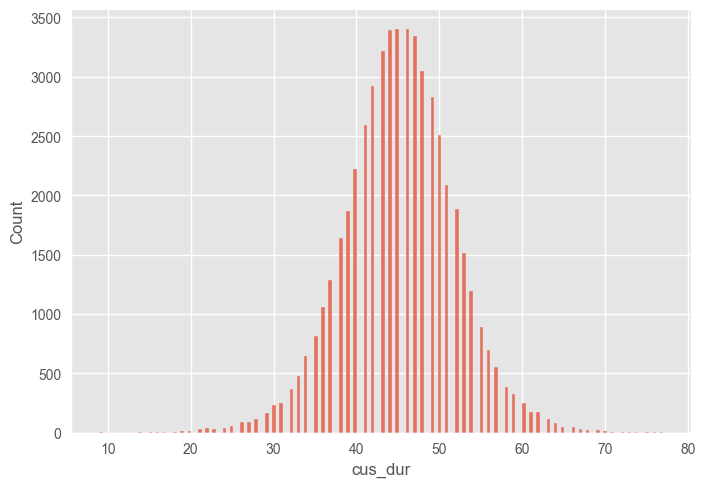

In [11]:
sns.histplot(x='cus_dur', data=df_demo)
plt.show()

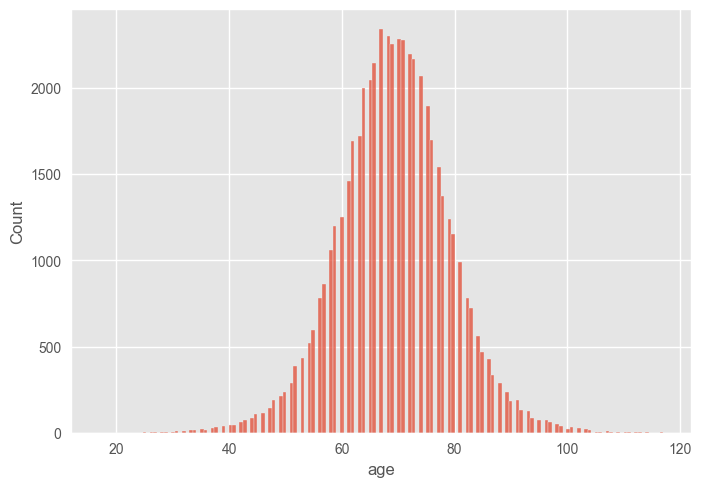

In [12]:
sns.histplot(x='age', data=df_demo)
plt.show()

<Axes: xlabel='gender', ylabel='count'>

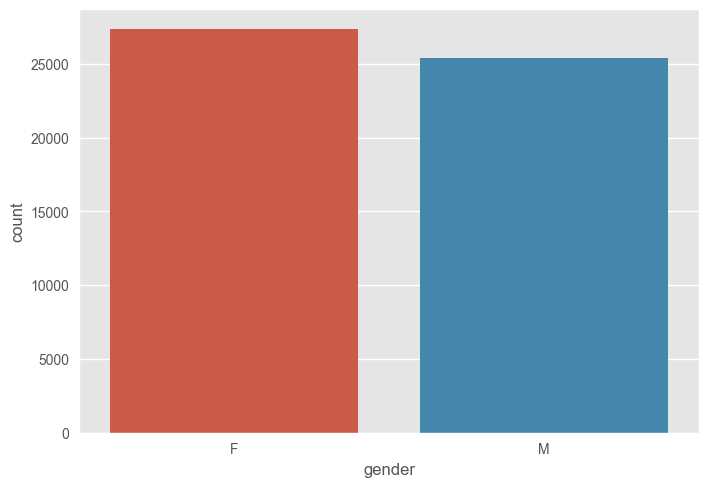

In [13]:
sns.countplot(x='gender', data=df_demo)

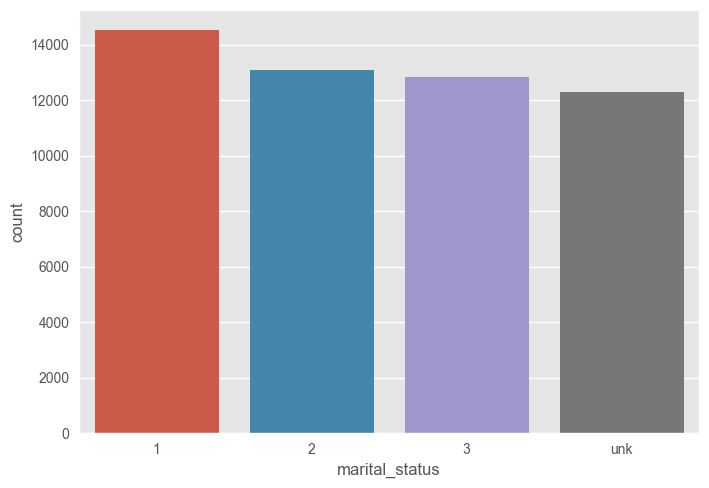

In [14]:
sns.countplot(x='marital_status', data=df_demo, order=sorted(df_demo['marital_status'].unique()))
plt.show()

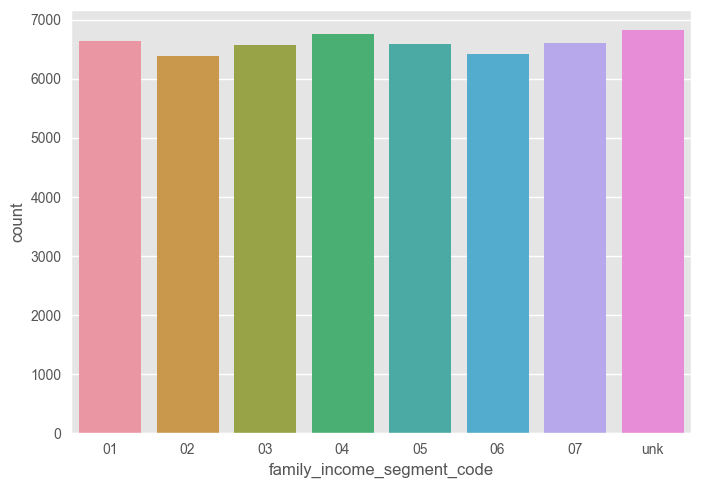

In [15]:
# sns.countplot(x='family_income_segment_code', data=df_demo, order=df_demo['family_income_segment_code'].value_counts().index)
sns.countplot(x='family_income_segment_code', data=df_demo, order=sorted(df_demo['family_income_segment_code'].unique()))
plt.show()

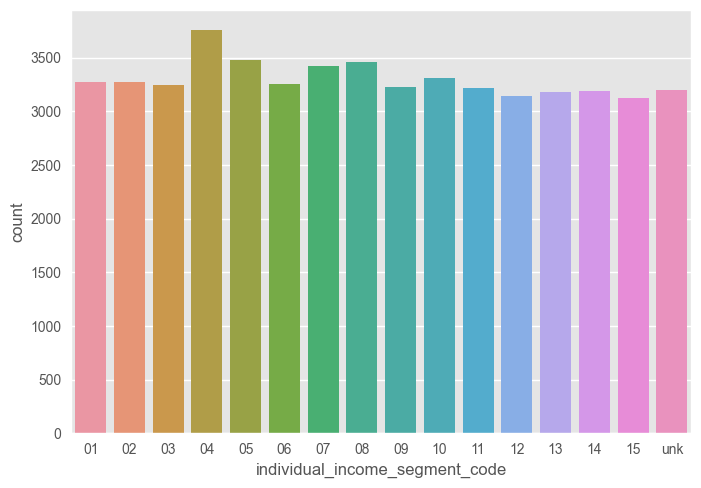

In [16]:
sns.countplot(x='individual_income_segment_code', data=df_demo, order=sorted(df_demo['individual_income_segment_code'].unique()))
plt.show()

In [17]:
# crlmt_inc = df_cardinfo.groupby('user_id').agg(
#     avg_crlmt=('cr_lmt_amt', 'mean')).reset_index().merge(
#         df_demo.loc[:,['user_id', 'individual_income_segment_code', 'family_income_segment_code']], on='user_id')

# print(crlmt_inc['family_income_segment_code'].value_counts(normalize=True))

# print(crlmt_inc.loc[crlmt_inc['avg_crlmt']>2000000, :]['family_income_segment_code'].value_counts(normalize=True))

In [18]:
# famind_score = df_demo['family_income_segment_code'] + '-' + df_demo['individual_income_segment_code']
# famind_score.value_counts()

In [19]:
# df_demo['family_income_segment_code'] = df_demo['family_income_segment_code'].astype(int)
# df_demo['individual_income_segment_code'] = df_demo['individual_income_segment_code'].astype(int)

In [20]:
df_demo_y = df_demo.merge(df_y, on='user_id', how='right')
df_demo_y.head()

,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code,cus_dur,age,label
0,2723,1978-10-24,1938.0,F,2,unk,15,39,79.0,1.0
1,44088,1985-11-19,1952.0,M,unk,03,03,32,65.0,1.0
2,3139,1979-08-17,1951.0,F,3,04,08,38,66.0,0.0
3,25596,1969-07-04,1938.0,M,1,01,03,48,79.0,0.0
4,15409,1974-05-09,1947.0,M,unk,unk,14,43,70.0,0.0


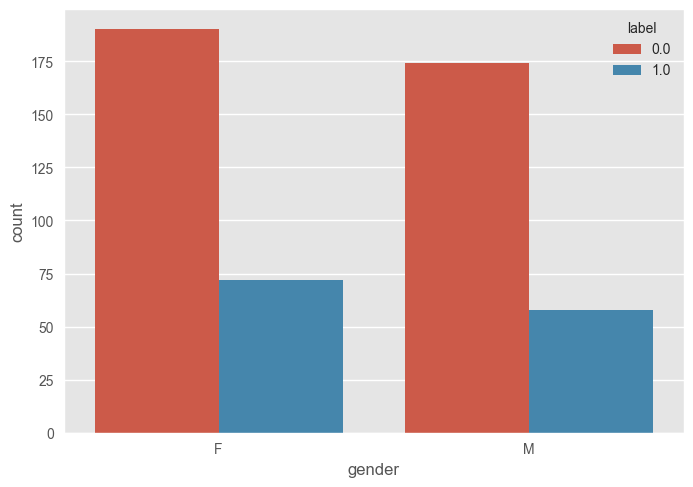

In [21]:
sns.countplot(x='gender', hue='label', data=df_demo_y)
plt.show()

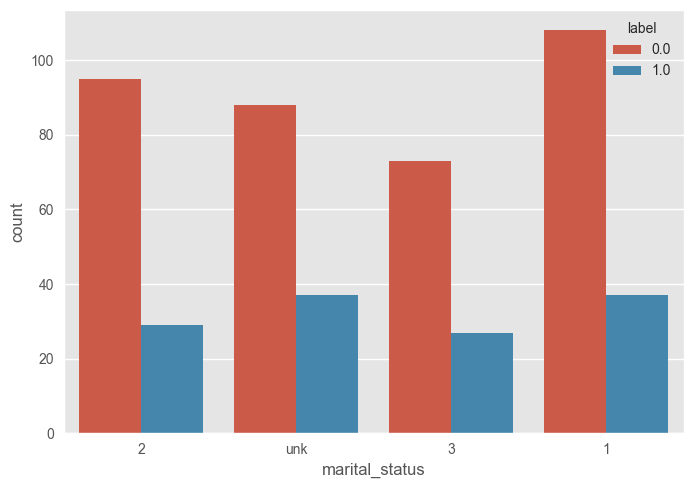

In [22]:
sns.countplot(x='marital_status', hue='label', data=df_demo_y)
plt.show()

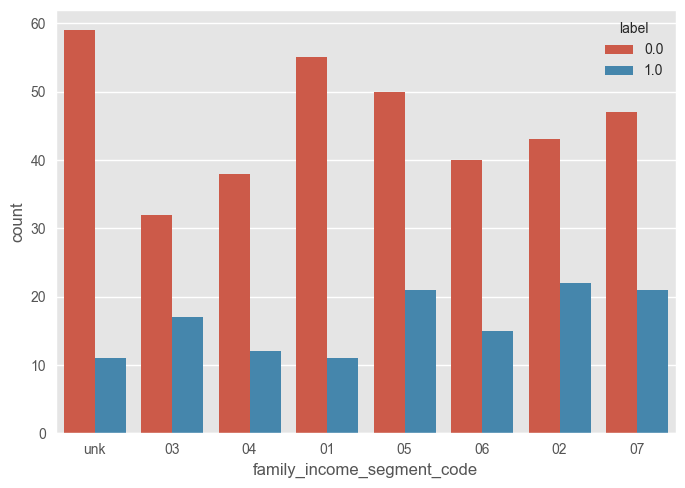

In [23]:
sns.countplot(x='family_income_segment_code', hue='label', data=df_demo_y)
plt.show()

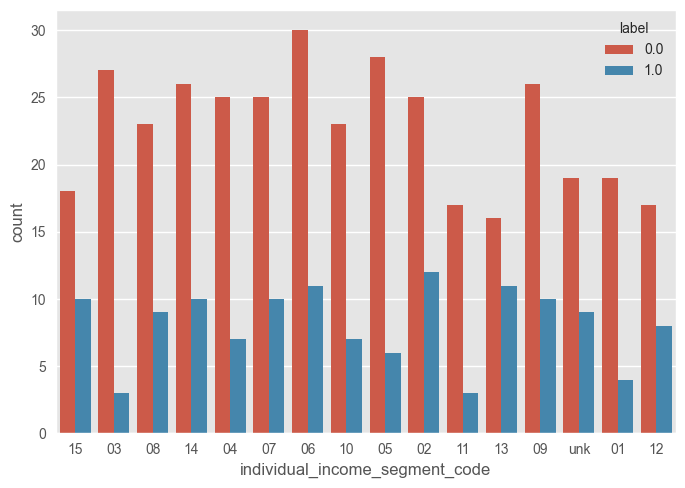

In [24]:
sns.countplot(x='individual_income_segment_code', hue='label', data=df_demo_y)
plt.show()

In [25]:
df_demo_y.groupby('marital_status')['label'].mean()

marital_status
1      0.255172
2      0.233871
3      0.270000
unk    0.296000
Name: label, dtype: float64

In [26]:
df_demo_y.groupby('family_income_segment_code')['label'].mean()

family_income_segment_code
01     0.166667
02     0.338462
03     0.346939
04     0.240000
05     0.295775
06     0.272727
07     0.308824
unk    0.157143
Name: label, dtype: float64

In [27]:
df_demo_y.groupby('individual_income_segment_code')['label'].mean()

individual_income_segment_code
01     0.173913
02     0.324324
03     0.100000
04     0.218750
05     0.176471
06     0.268293
07     0.285714
08     0.281250
09     0.277778
10     0.233333
11     0.150000
12     0.320000
13     0.407407
14     0.277778
15     0.357143
unk    0.321429
Name: label, dtype: float64

## df_cardinfo

<Axes: xlabel='bill_cyc', ylabel='Count'>

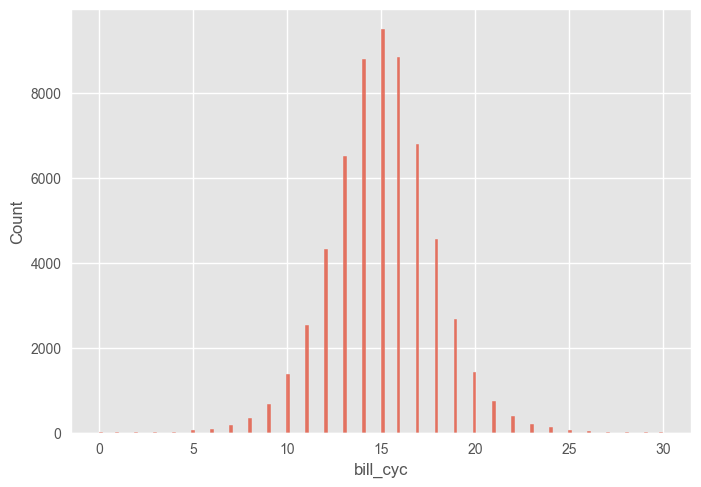

In [28]:
sns.histplot(df_cardinfo['bill_cyc'])

<Axes: xlabel='cr_lmt_amt', ylabel='Count'>

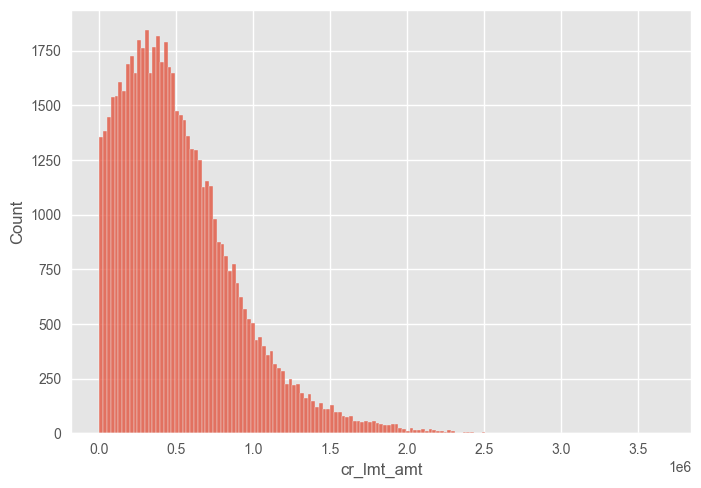

In [29]:
sns.histplot(df_cardinfo['cr_lmt_amt'])

In [30]:
# test = pd.merge(df_cardinfo[['user_id', 'cr_lmt_amt']], df_demo[['user_id', 'individual_income_segment_code']], on='user_id')
# sns.scatterplot(x='individual_income_segment_code', y='cr_lmt_amt', data=test)

In [31]:
df_cardinfo_y = df_cardinfo.merge(df_y, on='user_id', how='right')
df_cardinfo_y.head()

,user_id,bill_cyc,cr_lmt_amt,card_no,label
0,2723,27.0,642000,3368,1.0
1,44088,15.0,1581000,51033,1.0
2,3139,14.0,524000,3861,0.0
3,25596,16.0,411000,30367,0.0
4,15409,15.0,796000,18746,0.0


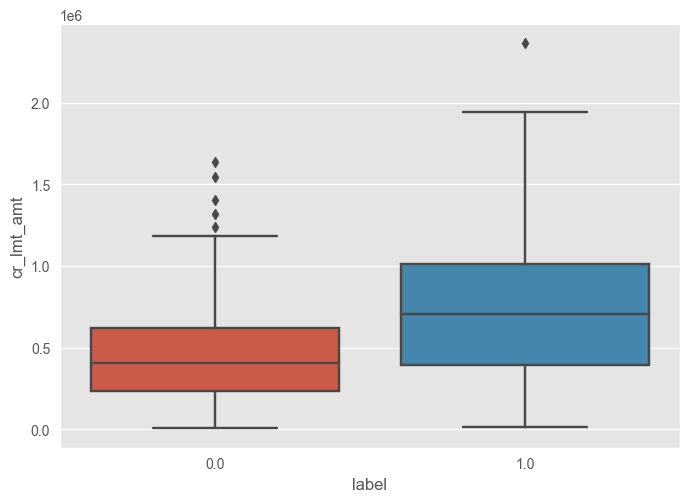

In [32]:
sns.boxplot(y='cr_lmt_amt', x='label', data=df_cardinfo_y.groupby(['user_id', 'label']).agg(cr_lmt_amt=('cr_lmt_amt', 'mean')).reset_index())
plt.show()

## df_cctxn

<Axes: xlabel='txn_month', ylabel='count_user'>

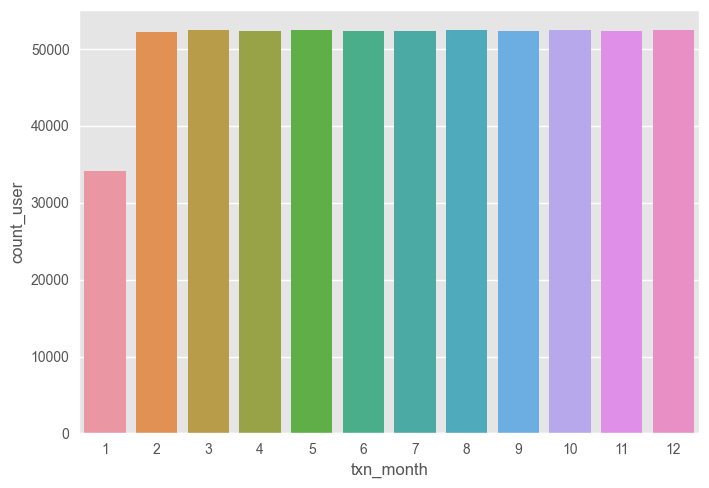

In [33]:
sns.barplot(y='count_user', x='txn_month', data=df_cctxn.groupby(['txn_month']).agg(count_user=('user_id', 'nunique')).reset_index())

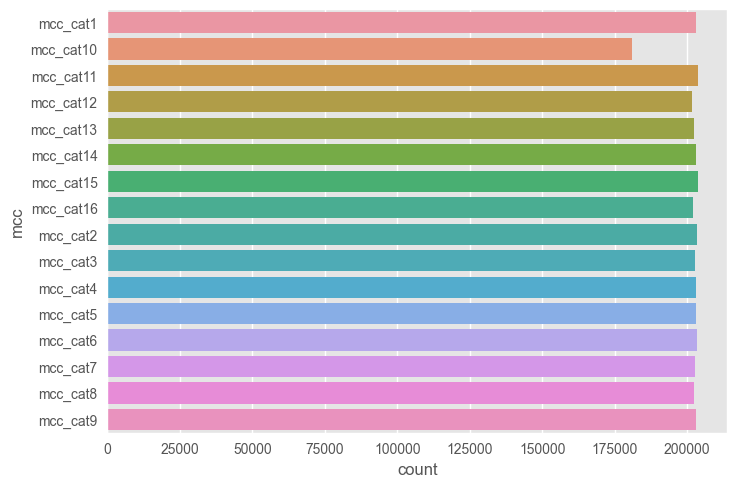

In [34]:
sns.countplot(y='mcc', data=df_cctxn, order=sorted(df_cctxn['mcc'].unique()))
# plt.xticks(rotation=90)
plt.show()

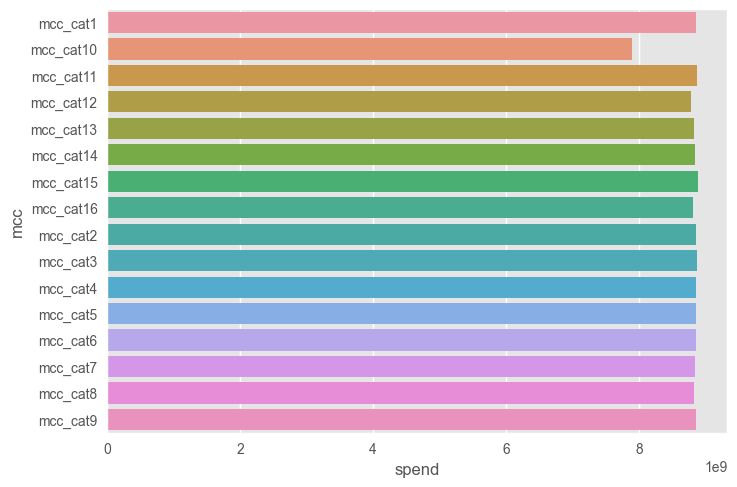

In [35]:
spend_mcc = df_cctxn.groupby('mcc').agg(spend=('txn_amt', 'sum')).reset_index()
sns.barplot(x='spend', y='mcc', data=spend_mcc, estimator="sum")
# sns.barplot(x='txn_amt', y='mcc', data=df_cctxn, estimator="sum")
plt.show()

In [36]:
df_cctxn_y = df_cctxn.merge(df_y, on='user_id', how='right')
df_cctxn_y.head()

,mcc,txn_dt,user_id,txn_amt,card_no,txn_ym,txn_month,label
0,mcc_cat11,2017-11-04,2723,125045.0,3368.0,2017-11,11,1.0
1,mcc_cat13,2017-10-13,2723,130143.0,3368.0,2017-10,10,1.0
2,mcc_cat16,2017-04-18,2723,24128.0,3368.0,2017-04,4,1.0
3,mcc_cat2,2017-08-07,2723,40044.0,3368.0,2017-08,8,1.0
4,mcc_cat12,2017-10-01,2723,54913.0,3368.0,2017-10,10,1.0


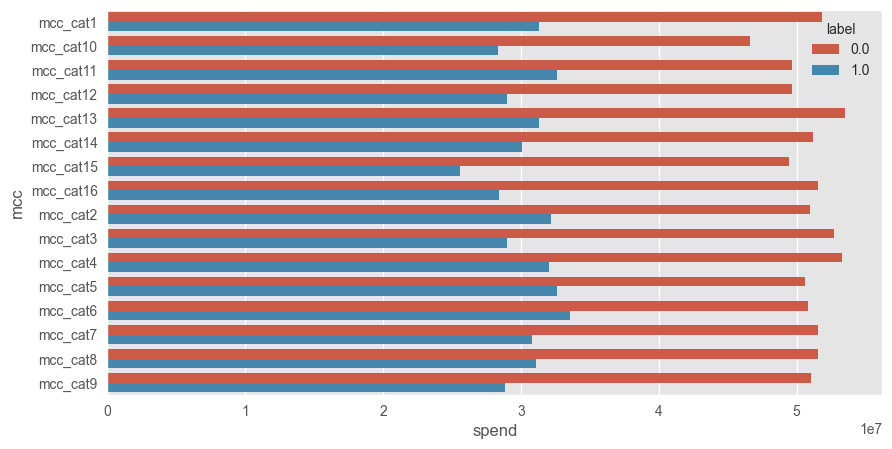

In [37]:
plt.figure(figsize=(10,5))
spend_mcc_y = df_cctxn_y.groupby(['mcc', 'label']).agg(spend=('txn_amt', 'sum')).reset_index()
sns.barplot(y='mcc', x='spend', hue='label', data=spend_mcc_y, estimator="sum")
plt.show()

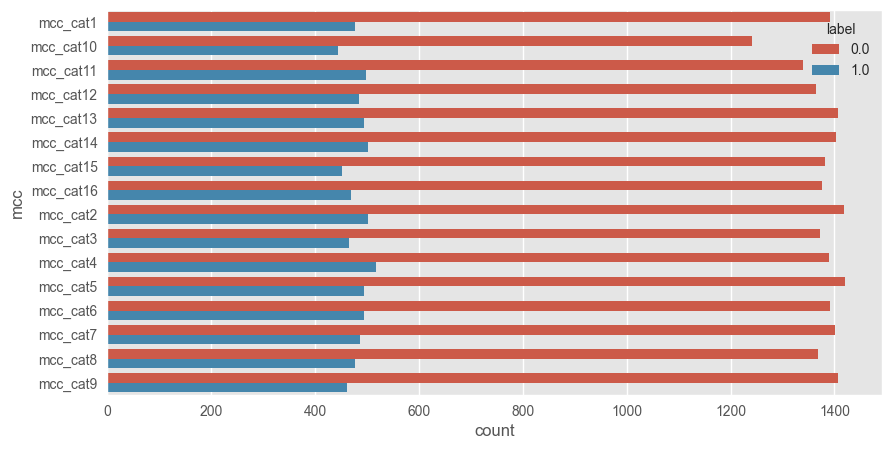

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(y='mcc', hue='label', data=df_cctxn_y, order=sorted(df_cctxn_y['mcc'].unique()))
plt.show()

## df_dtxn

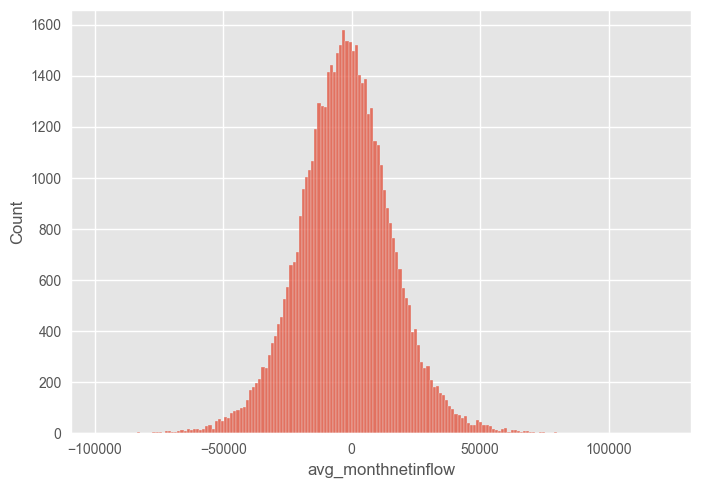

In [39]:
sns.histplot(x=df_dtxn.groupby('user_id').agg(avg_monthnetinflow=('change','mean'))['avg_monthnetinflow'])
plt.show()

In [40]:
df_dtxn_y = df_dtxn.merge(df_y, on='user_id', how='right')
df_dtxn_y.head()

,user_id,mm,amt_in,amt_out,change,label
0,2723,10,26114.0,128331.0,-102217.0,1.0
1,2723,11,0.0,54767.0,-54767.0,1.0
2,2723,2,72695.0,110524.0,-37829.0,1.0
3,2723,3,0.0,82986.0,-82986.0,1.0
4,2723,5,41468.0,47418.0,-5950.0,1.0


# Cohort

In [41]:
df_cohort = df_cctxn.copy()
df_cohort = df_cctxn[['user_id', 'txn_ym']].drop_duplicates()

df_cohort['cohort'] = df_cohort.groupby('user_id')['txn_ym'].transform('min')

df_cohort = df_cohort.groupby(['cohort', 'txn_ym']).agg(n_customers=('user_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort['txn_ym'] - df_cohort['cohort']).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

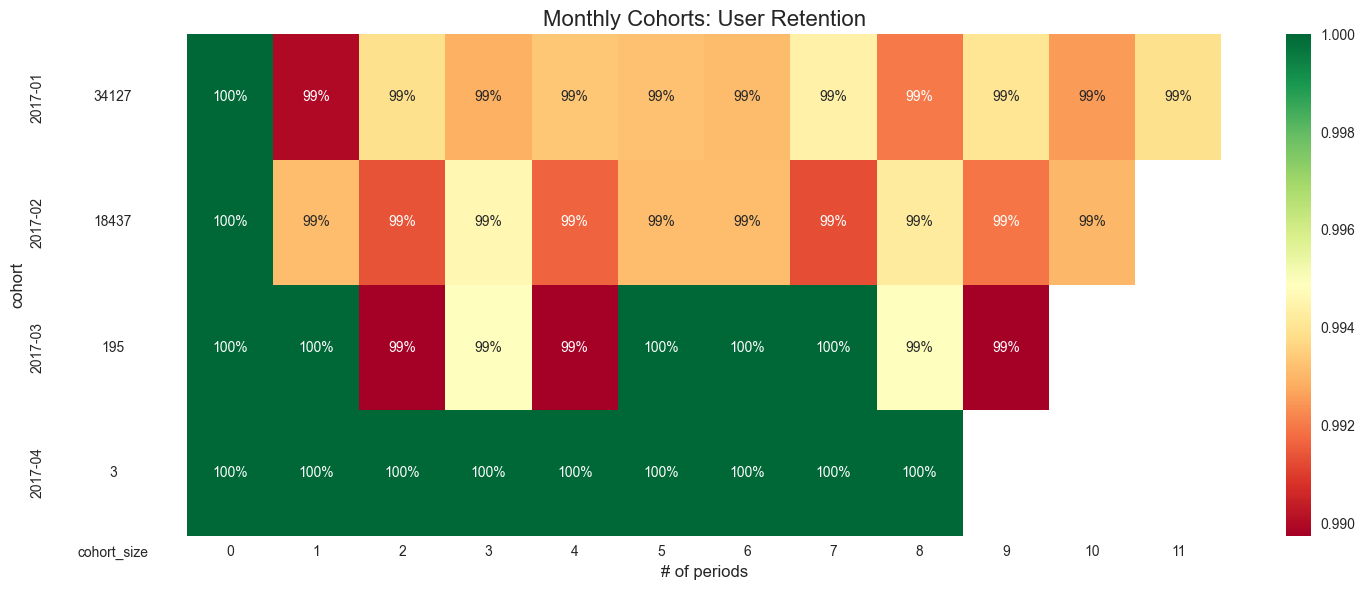

In [42]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Customer Movement Analysis

In [83]:
df_churn = df_cctxn.copy()
df_churn = df_churn[['user_id', 'txn_ym']].drop_duplicates().sort_values(by='txn_ym').reset_index(drop=True)
df_churn['start_month'] = df_churn.groupby('user_id')['txn_ym'].transform('min')
df_churn['period_number'] = (df_churn['txn_ym'] - df_churn['start_month']).apply(attrgetter('n')).astype(int)

df_churn = df_churn[df_churn['user_id']<10].reset_index(drop=True)

df_churn.tail(3)

,user_id,txn_ym,start_month,period_number
110,8,2017-12,2017-01,11
111,7,2017-12,2017-01,11
112,2,2017-12,2017-01,11


In [84]:
# set status labels

df_churn['labels'] = df_churn.apply(lambda row: 'new' if row['txn_ym'] == row['start_month'] else '', axis=1)
maxmonth = df_churn['txn_ym'].max()

for user_id in df_churn['user_id'].unique() :
    period = df_churn.loc[df_churn['user_id'] == user_id, :]['period_number']
    n = 0
    
    for p in period:
        if n+1==p : 
            df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']].replace('','repeat')
            n+=1

        elif n+1 < p :
            last_order = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == n)]
            new_row = pd.DataFrame({'user_id': user_id, 'labels': 'churn', 'period_number':n+1, 'txn_ym':last_order['txn_ym'].values[0]+1}, index=[0])
            df_churn = pd.concat([new_row,df_churn.loc[:]])

            df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']].replace('','reactivated')
            n=p
            
    user_maxmonth = df_churn[df_churn['user_id'] == user_id]['txn_ym'].max()
    if user_maxmonth != maxmonth:
        new_row = pd.DataFrame({'user_id': user_id, 'labels': 'churn', 'period_number':p+1, 'txn_ym':user_maxmonth+1}, index=[0])
        df_churn = pd.concat([new_row,df_churn.loc[:]])

df_churn.tail(3)

,user_id,labels,period_number,txn_ym,start_month
110,8,repeat,11,2017-12,2017-01
111,7,repeat,11,2017-12,2017-01
112,2,repeat,11,2017-12,2017-01


In [85]:
df_churn_plot = pd.pivot_table(data=df_churn, values='user_id', index='txn_ym', columns='labels', aggfunc='count', fill_value=0).reset_index()
df_churn_plot['churn'] = -df_churn_plot['churn']
df_churn_plot['txn_ym'] = df_churn_plot['txn_ym'].astype('str')

df_churn_plot.tail(3)

labels,txn_ym,churn,new,reactivated,repeat
9,2017-10,-1,0,0,9
10,2017-11,0,0,1,9
11,2017-12,0,0,0,10


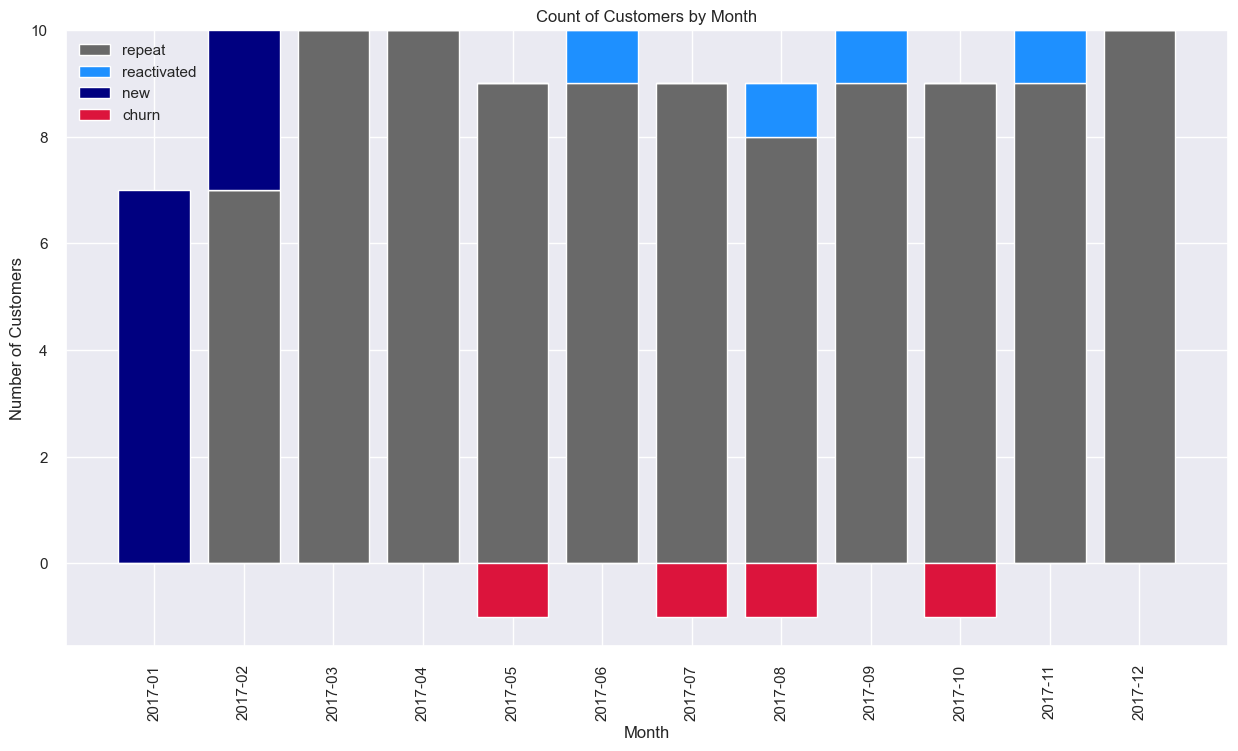

In [86]:
plt.figure(figsize=(15,8))
ax = plt.gca()
bottoms = 0 

labels = ['repeat', 'reactivated', 'new']
c = ['dimgrey', 'dodgerblue', 'navy']
for i in range(len(labels)):
  plt.bar( x = df_churn_plot['txn_ym'],
           height=df_churn_plot[labels[i]],
           color = c[i],
           bottom=bottoms,
           label=labels[i])

  bottoms += df_churn_plot[labels[i]].fillna(0)

ax.bar(height=df_churn_plot['churn'], 
       x=df_churn_plot['txn_ym'], 
       color='crimson', 
       bottom=0,
       label='churn')

plt.xticks(rotation='vertical')

plt.legend(loc='upper left')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Count of Customers by Month')

plt.show()

# Feature Engineering

In [47]:
# # Find the most bought category for each customer
# cust_dict = {'user_id':[],
#             'most_buying_cat':[]}

# cust_cat = df_cctxn.groupby(['user_id','mcc'])['mcc'].agg(qty='count').reset_index()

# for i in cust_cat['user_id'].unique():
#     cust_dict['user_id'].append(i)
#     cust = cust_cat.loc[cust_cat['user_id']==i,:]

#     if len(cust.loc[cust['qty']==cust['qty'].max()]['mcc']) == 1:
#         cust_dict['most_buying_cat'].append(cust.loc[cust['qty']==cust['qty'].max()]['mcc'].reset_index(drop=True)[0])
#     elif len(cust.loc[cust['qty']==cust['qty'].max()]['mcc']) > 1:
#         # if most buying cat more than one convert to list
#         cust_dict['most_buying_cat'].append(list(cust.loc[cust['qty']==cust['qty'].max()]['mcc']))

In [48]:
# create feature df
df_feature = df_demo[['user_id']].drop_duplicates().sort_values(by='user_id').reset_index(drop=True)

# aggreate data and merge with feature dataframe
df_feature = df_feature.merge(
    df_cardinfo.groupby('user_id').agg(
        avg_crlmt = ('cr_lmt_amt', 'mean')
    ), on='user_id', how='left')

# Personal information of customers
df_feature = df_feature.merge(
    df_demo.loc[:, ['user_id', 'cus_dur', 'age']]
    , on='user_id')

# Credit card transaction log dataframe
df_feature = df_feature.merge(
    df_cctxn.groupby('user_id').agg(
        card_count = ('card_no', 'nunique'), # number of cards
        total_spend = ('txn_amt', 'sum'), # total spending of customer
        avg_spend = ('txn_amt', 'mean'), # Average spending of customer per transaction
        count_txn = ('txn_amt', 'count'), # count of transaction
        last_txn = ('txn_dt', 'max'), # last transaction
        count_day = ('txn_dt', 'nunique'), # count of unique day transaction
        count_month = ('txn_month', 'nunique') # count of unique month transaction
    ), on='user_id', how='left')

# aggregate for 3 months period
df_feature = df_feature.merge(
    df_cctxn.loc[df_cctxn['txn_month'] > (df_cctxn['txn_month'].max() - 3), :].groupby('user_id').agg(
        count_txn_3m = ('txn_amt', 'count'), # total spending
        total_spend_3m = ('txn_amt', 'sum'), # count of transaction
        avg_spend_3m = ('txn_amt', 'mean'), # Average spending of customer per transaction
        count_day_3m = ('txn_dt', 'nunique'), # count of day transaction happened
        count_month_3m = ('txn_month', 'nunique'), # count of month transaction happened
    ), on='user_id', how='left')

# aggregate for 6 months period
df_feature = df_feature.merge(
    df_cctxn.loc[df_cctxn['txn_month'] > (df_cctxn['txn_month'].max() - 6), :].groupby('user_id').agg(
        count_txn_6m = ('txn_amt', 'count'), # total spending
        total_spend_6m = ('txn_amt', 'sum'), # count of transaction
        avg_spend_6m = ('txn_amt', 'mean'), # Average spending of customer per transaction
        count_day_6m = ('txn_dt', 'nunique'), # count of day transaction happened
        count_month_6m = ('txn_month', 'nunique') # count of month transaction happened
    ), on='user_id', how='left')

# recency = duration between last transaction of customer and 2017-12-31
df_feature['recency'] = (df_cctxn['txn_dt'].max() - df_feature['last_txn']).dt.days

################################

# Saving account balance aggregated by months dataframe
df_feature = df_feature.merge(
    df_sabal.groupby('user_id').agg(
        avg_sabal_month = ('max_sa_bal', 'mean') # avg saving balance by months
        ), on='user_id', how='left')
        
################################

# Incoming and outgoing transactions aggregated by months (exclude credit card transactions) dataframe
df_feature = df_feature.merge(
    df_dtxn.groupby('user_id').agg(
        # avg_balchg_month = ('change', 'mean'),
        total_netinflow = ('change', 'sum'), # total net inflow transaction
        ), on='user_id', how='left')

################################

# # join with most buying cat df
# df_feature = df_feature.merge(pd.DataFrame(cust_dict), how='inner', on='user_id')

df_feature.drop(columns=['last_txn'], inplace=True)

df_feature.head()

,user_id,avg_crlmt,cus_dur,age,card_count,total_spend,avg_spend,count_txn,count_day,count_month,...,count_day_3m,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_netinflow
0,0,244000.0,42,71.0,1,1746107.0,31180.482143,56,53,12,...,13.0,3.0,27,852850.0,31587.037037,25,6,3,355838.916667,-29603.0
1,1,361000.0,49,63.0,1,2234391.0,34912.359375,64,56,12,...,22.0,3.0,37,1220829.0,32995.378378,32,6,0,317793.166667,-77698.0
2,2,385000.0,42,71.0,1,1632778.0,37971.581395,43,38,11,...,12.0,3.0,23,815837.0,35471.173913,21,5,10,405045.333333,214644.0
3,3,518000.0,43,90.0,1,2884456.0,64099.022222,45,42,10,...,15.0,3.0,32,1914940.0,59841.875000,30,6,6,513779.666667,162985.0
4,4,889000.0,51,78.0,1,2973483.0,69150.767442,43,39,10,...,10.0,2.0,21,1327124.0,63196.380952,19,5,0,391910.083333,-675871.0


In [49]:
df_feature.isnull().sum()

user_id            0
avg_crlmt          0
cus_dur            0
age                0
card_count         0
total_spend        0
avg_spend          0
count_txn          0
count_day          0
count_month        0
count_txn_3m       1
total_spend_3m     1
avg_spend_3m       1
count_day_3m       1
count_month_3m     1
count_txn_6m       0
total_spend_6m     0
avg_spend_6m       0
count_day_6m       0
count_month_6m     0
recency            0
avg_sabal_month    0
total_netinflow    0
dtype: int64

In [50]:
df_feature.fillna(0, inplace=True)

In [51]:
df_feature_train = df_feature.merge(df_y, on='user_id')
# df_feature_train.drop(columns=['most_buying_cat'], inplace=True)
df_feature_train.tail()

,user_id,avg_crlmt,cus_dur,age,card_count,total_spend,avg_spend,count_txn,count_day,count_month,...,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_netinflow,label
489,52039,617000.0,47,74.0,1,2057662.0,30259.735294,68,56,12,...,3.0,33,1121186.0,33975.333333,25,6,4,505166.583333,254411.0,0.0
490,52069,891000.0,51,54.0,1,2717461.0,49408.381818,55,51,12,...,3.0,33,1908248.0,57825.696970,30,6,0,426845.750000,-220746.0,0.0
491,52607,54000.0,50,66.0,1,2741077.0,47259.948276,58,51,12,...,3.0,34,1803355.0,53039.852941,30,6,0,456666.000000,107645.0,0.0
492,52619,548000.0,47,77.0,1,3080829.0,46679.227273,66,61,11,...,3.0,42,1862461.0,44344.309524,38,6,16,340521.416667,-290184.0,0.0
493,52708,544000.0,44,73.0,1,1781294.0,34927.333333,51,49,11,...,3.0,26,940981.0,36191.576923,25,6,0,479179.000000,-24820.0,0.0


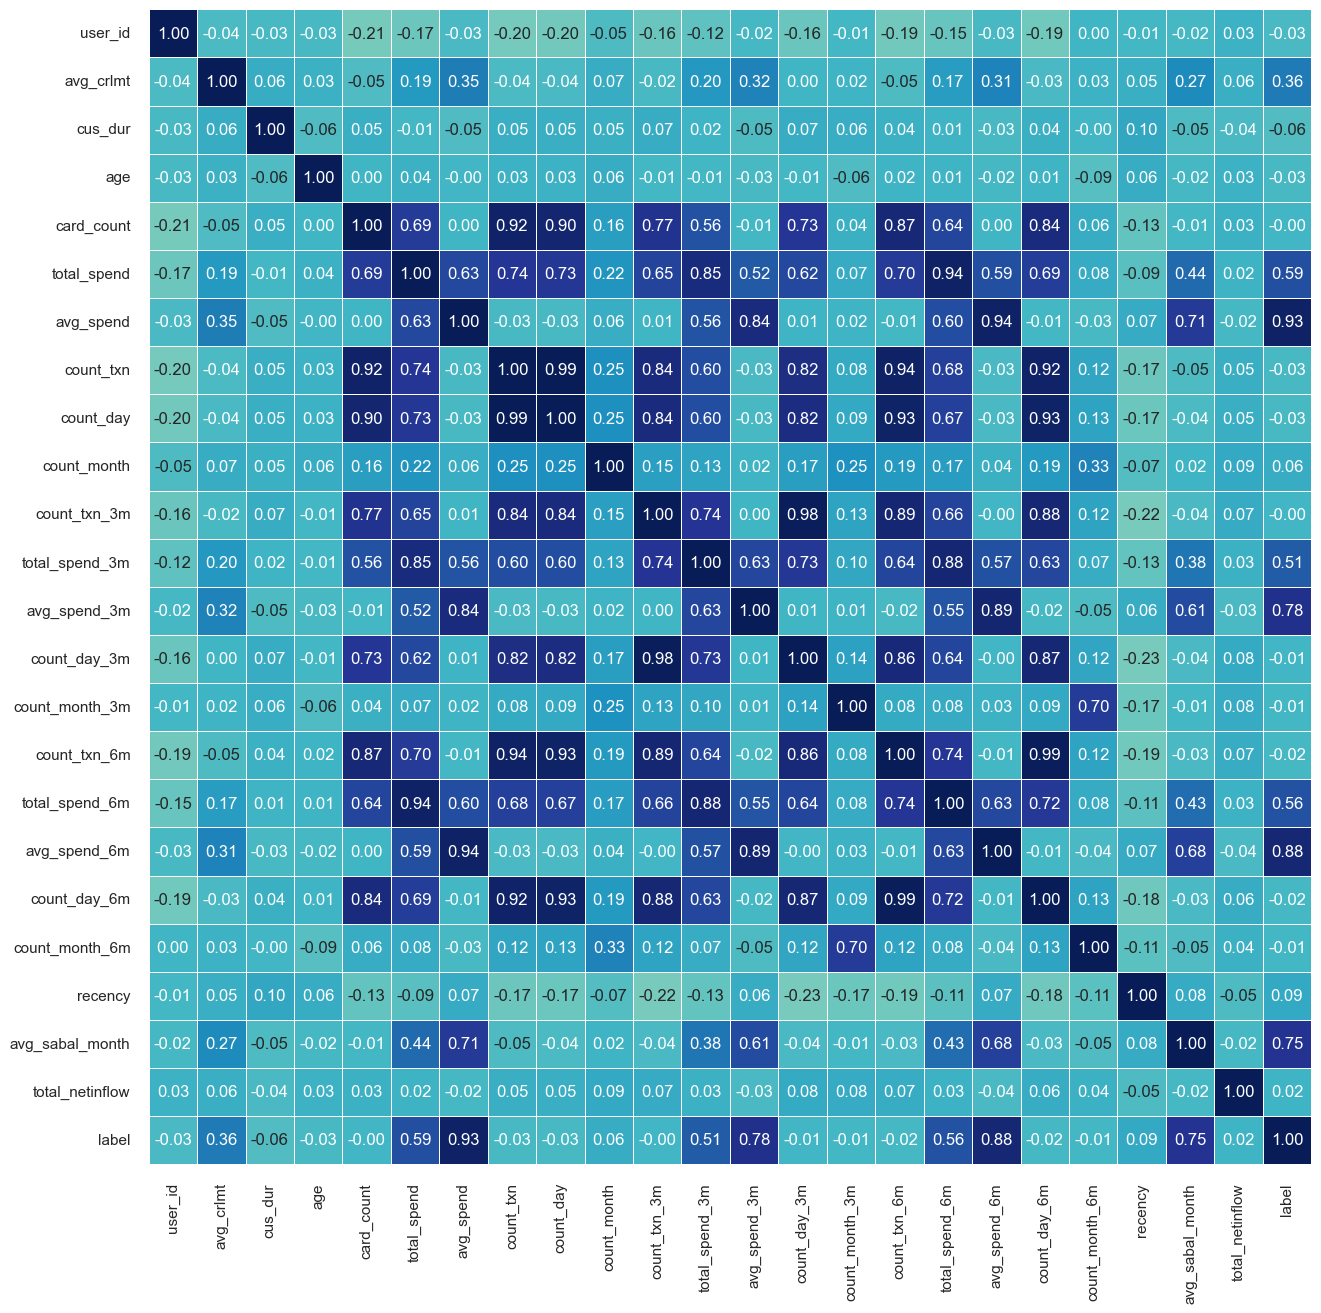

In [52]:
sns.set(rc={"figure.figsize": (15, 15)})
sns.heatmap(
    df_feature_train.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

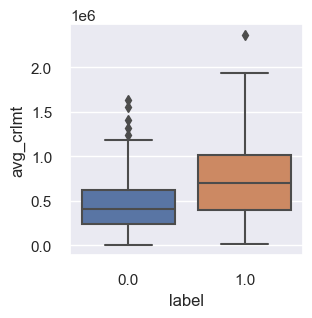

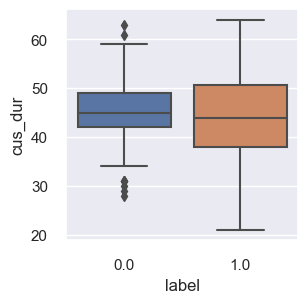

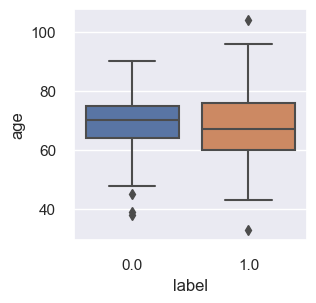

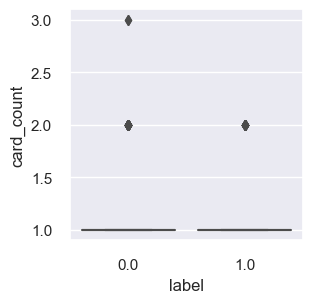

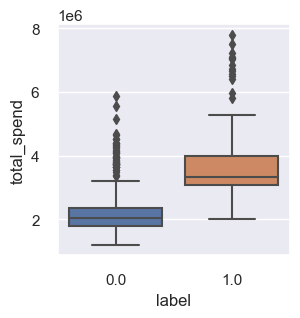

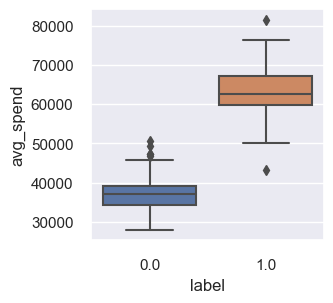

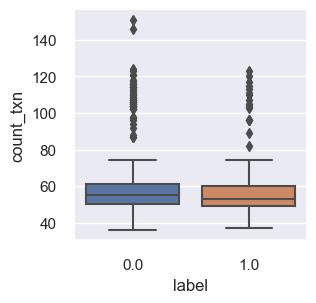

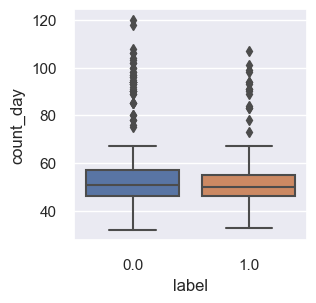

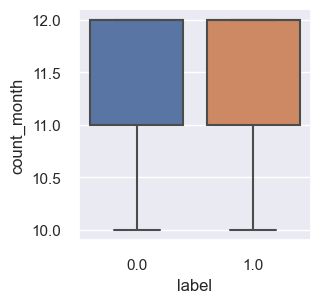

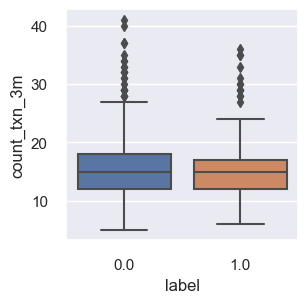

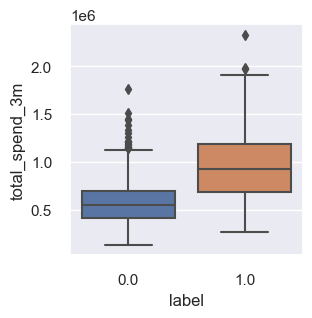

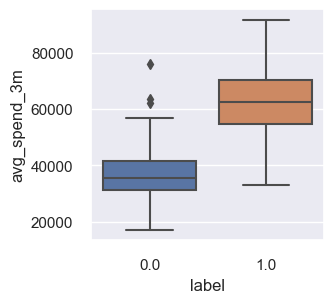

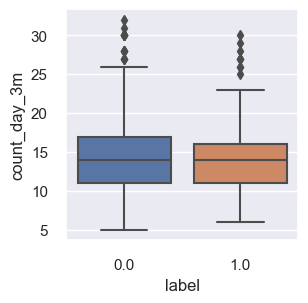

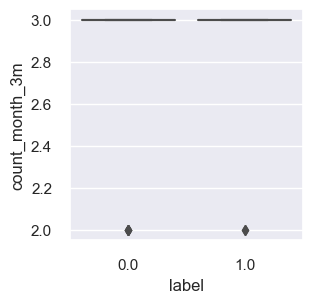

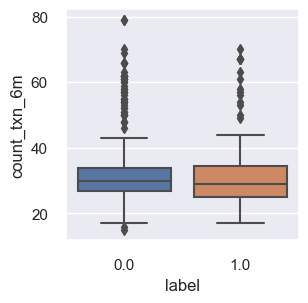

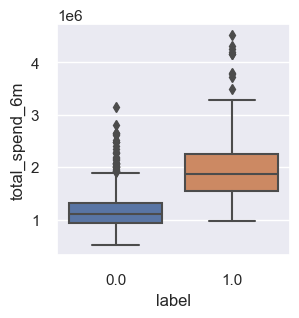

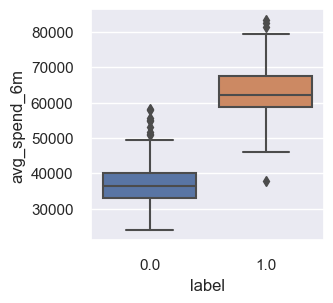

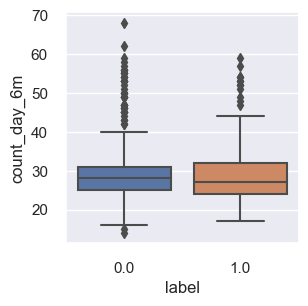

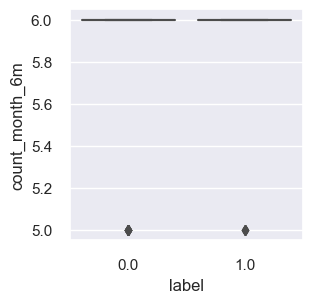

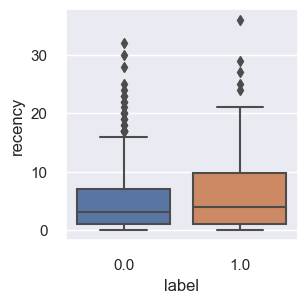

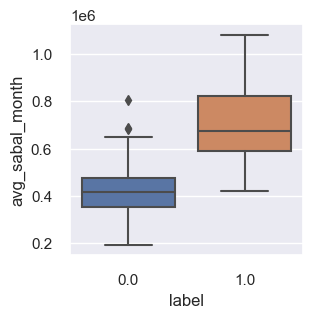

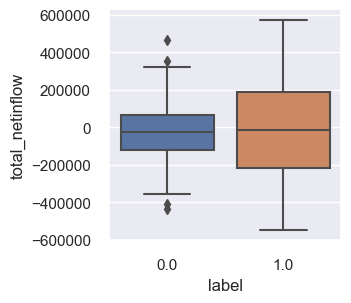

In [53]:
for col in df_feature_train.columns[1:-1]:
    plt.figure(figsize=(3,3))
    sns.boxplot(x='label', y=col, data=df_feature_train)
    plt.show()

In [54]:
# drop uncorrelated features
df_feature_train.drop(columns=['cus_dur', 'age', 'card_count', 'total_netinflow'], inplace=True)

# Model and Evaluation

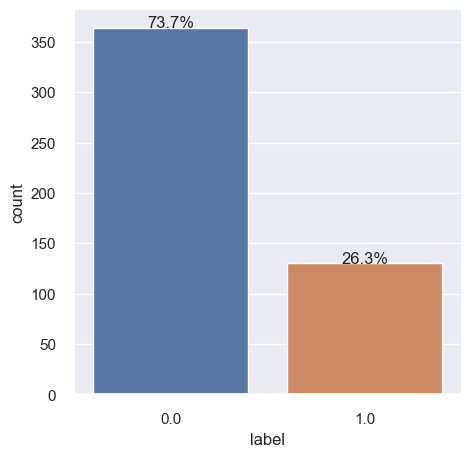

In [55]:
plt.figure(figsize=(5,5))

# Create the countplot
ax = sns.countplot(data=df_y, x='label')

# Add percentage labels on top of each bar
total = len(df_y['label'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{height/total:.1%}', ha="center")

# Show the plot
plt.show()

using pycaret to proform cross-validation

In [56]:
X = df_feature_train.drop(columns=['user_id', 'label'])
y = df_feature_train['label']

X_col = X.columns

# scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [57]:
# split train test data 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# handle imbalanced data in training dataset with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [58]:
# init setup
s = ClassificationExperiment()
s.setup(data = df_feature_train, target = 'label', train_size=0.7, fix_imbalance_method='SMOTE', session_id = seed)

# compare models
best = s.compare_models()

,Description,Value
0,Session id,0
1,Target,label
2,Target type,Binary
3,Original data shape,"(494, 20)"
4,Transformed data shape,"(494, 20)"
5,Transformed train set shape,"(345, 20)"
6,Transformed test set shape,"(149, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9971,0.9996,0.9889,1.0000,0.9941,0.9922,0.9925,0.6810
ridge,Ridge Classifier,0.9971,0.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.2490
lda,Linear Discriminant Analysis,0.9971,1.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.2790
xgboost,Extreme Gradient Boosting,0.9971,1.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.3030
dt,Decision Tree Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.3130
rf,Random Forest Classifier,0.9942,1.0000,0.9889,0.9909,0.9894,0.9854,0.9859,0.2960
ada,Ada Boost Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.2460
gbc,Gradient Boosting Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.2750
et,Extra Trees Classifier,0.9913,1.0000,0.9889,0.9809,0.9841,0.9782,0.9789,0.3620
lightgbm,Light Gradient Boosting Machine,0.9885,0.9980,0.9889,0.9709,0.9788,0.9709,0.9719,0.2810


In [59]:
# Convert pycaret evaluation scores to DataFrame
model_scores_df = s.pull()
model_scores_df = pd.DataFrame(model_scores_df)

# Calculate F2
model_scores_df['F2'] = 5*model_scores_df['Prec.']*model_scores_df['Recall']/((4*model_scores_df['Prec.']) + model_scores_df['Recall'])

model_scores_df.sort_values(by='F2', ascending=False)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),F2
lr,Logistic Regression,0.9971,0.9996,0.9889,1.0000,0.9941,0.9922,0.9925,0.681,0.991100
ridge,Ridge Classifier,0.9971,0.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.249,0.991100
lda,Linear Discriminant Analysis,0.9971,1.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.279,0.991100
xgboost,Extreme Gradient Boosting,0.9971,1.0000,0.9889,1.0000,0.9941,0.9922,0.9925,0.303,0.991100
dt,Decision Tree Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.313,0.989299
rf,Random Forest Classifier,0.9942,1.0000,0.9889,0.9909,0.9894,0.9854,0.9859,0.296,0.989299
ada,Ada Boost Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.246,0.989299
gbc,Gradient Boosting Classifier,0.9942,0.9924,0.9889,0.9909,0.9894,0.9854,0.9859,0.275,0.989299
et,Extra Trees Classifier,0.9913,1.0000,0.9889,0.9809,0.9841,0.9782,0.9789,0.362,0.987290
lightgbm,Light Gradient Boosting Machine,0.9885,0.9980,0.9889,0.9709,0.9788,0.9709,0.9719,0.281,0.985247


In [73]:
# model
model = XGBClassifier(
    objective='binary:logistic',
    gamma=0.1,
    max_depth=3,
    subsample=0.7,
    reg_alpha=0.5,  # L1 regularization term
    reg_lambda=1.0,  # L2 regularization term
    random_state=seed
)

# model = XGBClassifier(random_state=seed)
model.fit(X_resampled, y_resampled)

# evaluate model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       108
         1.0       1.00      1.00      1.00        41

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149



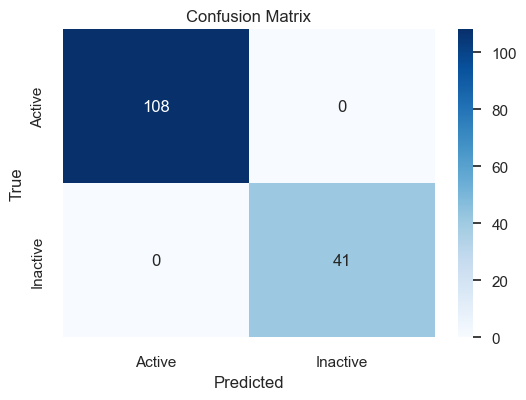

In [74]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [75]:
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f2 = 5*precision*recall/((4*precision)+recall)

print('Evaluation score of Inactive Customers')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F2: {f2:.4f}')

Evaluation score of Inactive Customers
Precision: 1.0000
Recall: 1.0000
F2: 1.0000


In [76]:
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f2 = 5*precision*recall/((4*precision)+recall)

print('Evaluation score of Active Customers')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F2: {f2:.4f}')

Evaluation score of Active Customers
Precision: 1.0000
Recall: 1.0000
F2: 1.0000


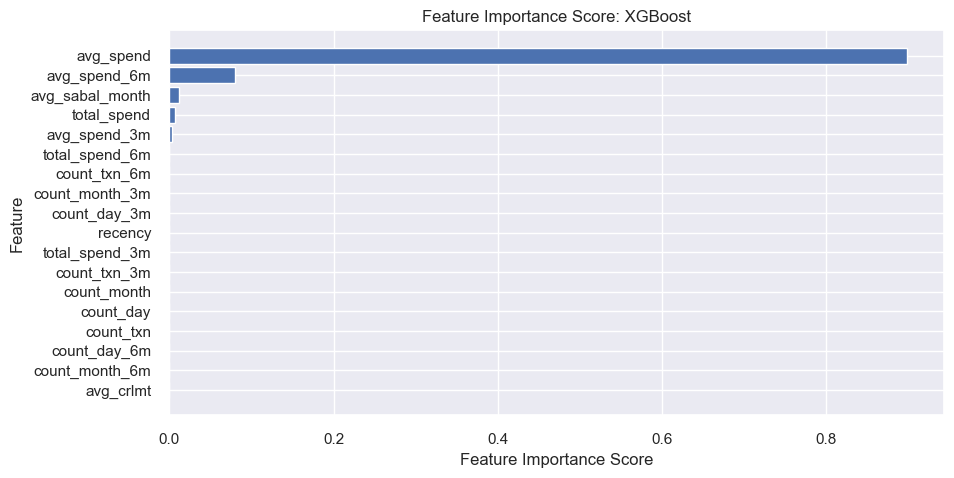

In [80]:
# Create a sgboost classifier
model = XGBClassifier(
    objective='binary:logistic',
    gamma=0.1,
    max_depth=3,
    subsample=0.7,
    reg_alpha=0.5,  # L1 regularization term
    reg_lambda=1.0,  # L2 regularization term
    random_state=seed
)

# Train the classifier on your data
model.fit(X, y)

# Get the feature importance scores
importance_scores = model.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Plotting the feature importance
plt.figure(figsize=(10,5))
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [df_feature_train.columns[idx+1] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score: XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

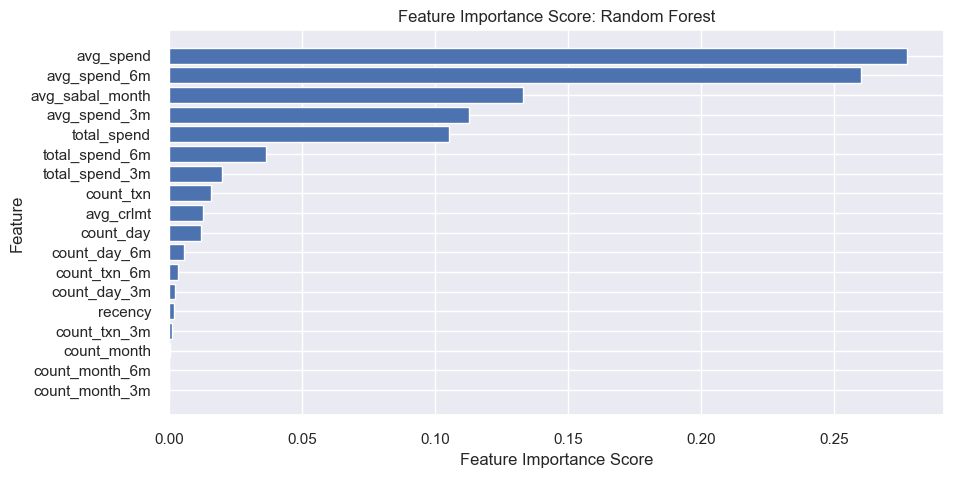

In [81]:
# Create a Random Forest classifier
model = RandomForestClassifier(random_state=seed)

# Train the classifier on your data
model.fit(X, y)

# Get the feature importance scores
importance_scores = model.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Plotting the feature importance
plt.figure(figsize=(10,5))
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [df_feature_train.columns[idx+1] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score: Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

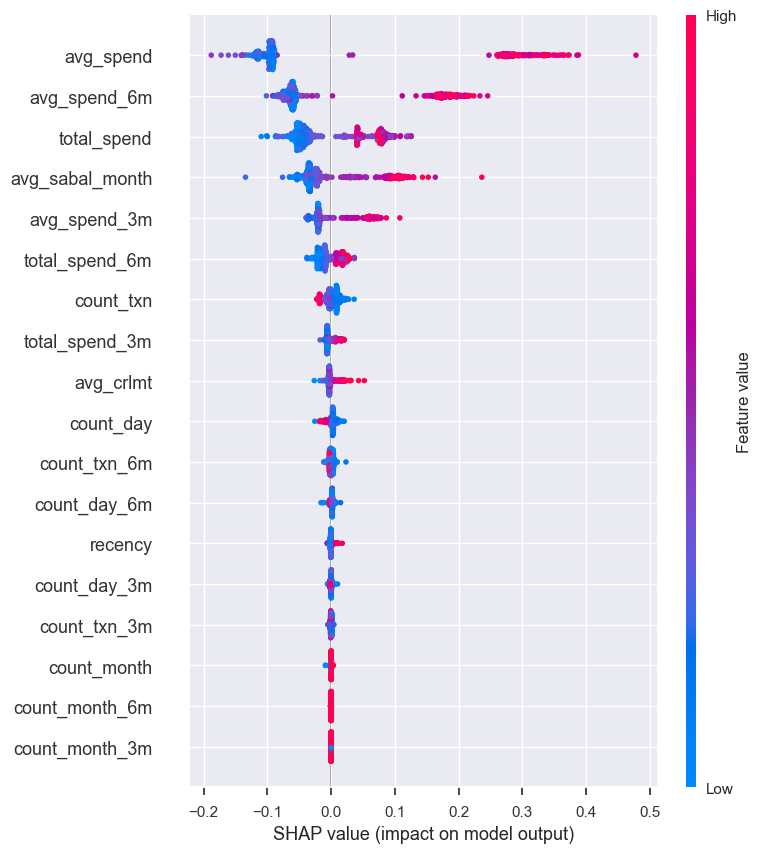

In [82]:
# Explain the model predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Create a SHAP summary plot
shap.summary_plot(shap_values[1], X, feature_names=X_col)

# Optional Model

In [ ]:
df_cctxn_q1_3 = df_cctxn.loc[df_cctxn['txn_month']<=9,:]
df_cctxn_q4 = df_cctxn.loc[df_cctxn['txn_month']>9,:][['user_id']].drop_duplicates()

In [ ]:
df_cctxn_q1_3.nunique()

mcc              16
txn_dt          248
user_id       52762
txn_amt      172330
card_no       60296
txn_ym            9
txn_month         9
dtype: int64

In [ ]:
df_cctxn_q4.nunique()

user_id    52761
dtype: int64

In [ ]:
# # create feature df
# df_feature = df_demo[['user_id']].drop_duplicates().sort_values(by='user_id').reset_index(drop=True)

# # aggreate data and merge with feature dataframe

# # Credit card transaction log dataframe
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.groupby('user_id').agg(
#         card_count = ('card_no', 'nunique'), # number of cards
#         total_spend = ('txn_amt', 'sum'), # total spending
#         avg_spend = ('txn_amt', 'mean'), # average spending
#         total_txn = ('txn_amt', 'count'), # count of transaction
#         last_txn = ('txn_dt', 'max'), # last transaction
#         count_day = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month = ('txn_month', 'nunique') # count of month transaction happened
#     ), on='user_id')

# # aggregate for 3 months period
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.loc[df_cctxn_q1_3['txn_month'] > (df_cctxn_q1_3['txn_month'].max() - 3), :].groupby('user_id').agg(
#         total_txn_3m = ('txn_amt', 'count'), # total spending
#         total_spend_3m = ('txn_amt', 'sum'), # count of transaction
#         avg_spend_3m = ('txn_amt', 'mean'), # average spending
#         count_day_3m = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month_3m = ('txn_month', 'nunique'), # count of month transaction happened
#     ), on='user_id')

# # aggregate for 6 months period
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.loc[df_cctxn_q1_3['txn_month'] > (df_cctxn_q1_3['txn_month'].max() - 6), :].groupby('user_id').agg(
#         total_txn_6m = ('txn_amt', 'count'), # total spending
#         total_spend_6m = ('txn_amt', 'sum'), # count of transaction
#         avg_spend_6m = ('txn_amt', 'mean'), # average spending
#         count_day_6m = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month_6m = ('txn_month', 'nunique') # count of month transaction happened
#     ), on='user_id')

# # recency = duration between last transaction of customer and 2017-09-30
# df_feature['recency'] = (df_cctxn_q1_3['txn_dt'].max() - df_feature['last_txn']).dt.days

# ################################

# # Saving account balance aggregated by months dataframe
# df_feature = df_feature.merge(
#     df_sabal.loc[df_sabal['mm']<=9, :].groupby('user_id').agg(
#         avg_sabal_month = ('max_sa_bal', 'mean') # avg saving balance by months
#         ), on='user_id')
        
# ################################

# # Incoming and outgoing transactions aggregated by months (exclude credit card transactions) dataframe
# df_feature = df_feature.merge(
#     df_dtxn.loc[df_dtxn['mm']<=9, :].groupby('user_id').agg(
#         total_txnchg = ('change', 'sum'), # total net income transaction
#         ), on='user_id')

# ################################

# df_feature.drop(columns=['last_txn'], inplace=True)

# df_feature.head()

In [ ]:
# df_feature[df_feature['count_txn']<30]

,user_id,avg_crlmt,cus_dur,age,card_count,total_spend,avg_spend,count_txn,count_day,count_month,...,count_day_3m,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_netinflow
12009,12009,431000.0,41,76.0,1,881232.0,32638.222222,27,26,10,...,6.0,3.0,13,461411.0,35493.153846,12,6,15,579029.666667,-49631.0
35075,35075,393000.0,46,68.0,1,1006824.0,34718.068966,29,28,11,...,9.0,3.0,15,334236.0,22282.400000,14,6,3,416239.916667,-173004.0
49751,49751,918000.0,42,76.0,1,844913.0,32496.653846,26,25,10,...,4.0,3.0,10,299086.0,29908.600000,10,6,1,416860.583333,-47475.0
